### Modules

In [1]:
import pandas as pd
import logging
from youtube_search import YoutubeSearch
from pytubefix import YouTube
from pydub import AudioSegment

import re
import os
import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

os.makedirs('datasets/songs', exist_ok=True)
os.makedirs('datasets/wav_songs', exist_ok=True)

### Variables
```yaml
This module contains the configuration for the youtube search and download
You can change the configuration here

YOUTUBE_BASE_URL: The base url for the youtube search
YOUTUBE_SEARCH_MAX_RESULTS: The maximum number of results to return from the youtube search
YOUTUBE_CLIENT_TYPE: The type of client to use for the youtube search
YOUTUBE_MAX_VIDEO_LENGTH: The maximum length of a video in seconds
YOUTUBE_MIN_VIDEO_LENGTH: The minimum length of a video in seconds

SONG_SIZE_PER_TITLE: size (count) songs per title
SEGMENT_LENGTH: The length of each segment in seconds

LAGU_DAERAH_PATH: The path to the lagu daerah dataset
DOWNLOADED_SONGS_PATH: The path to the downloaded songs
SONGS_WAV_PATH: The path to the songs in wav format
```

In [2]:

YOUTUBE_BASE_URL = 'https://www.youtube.com/watch?v='
YOUTUBE_SEARCH_MAX_RESULTS = 40
YOUTUBE_CLIENT_TYPE='IOS'
YOUTUBE_MAX_VIDEO_LENGTH = 450
YOUTUBE_MIN_VIDEO_LENGTH = 30

SONG_SIZE_PER_TITLE=20
SEGMENT_LENGTH = 30

# LAGU_DAERAH_PATH = 'data/lagu_daerah.csv'
LAGU_DAERAH_PATH = 'data/lagu_daerah_alternatif.csv'
# LAGU_DAERAH_PATH = 'data/lagu_daerah_15.csv'
DOWNLOADED_SONGS_PATH = 'data/downloaded_songs.csv'
SONGS_WAV_PATH = 'data/songs_wav.csv'

### Load Scrapping Result

In [3]:
data = pd.read_csv(LAGU_DAERAH_PATH, sep=',')
data.head()

,nama_lagu,asal
0,Bungong Jeumpa,Aceh
1,Mecepat – Cepetan,Bali
2,Sarinande,Bali
3,Putri,Bali
4,Ratu Anom,Bali


### Search and Download Music Function

In [4]:
def search_yt(query, max_results=YOUTUBE_SEARCH_MAX_RESULTS):
    try:
        results = YoutubeSearch(query, max_results).to_dict()
        for result in results:
            result['url'] = YOUTUBE_BASE_URL + result['id']
        return results
    except Exception as e:
        logging.error(f"Error searching YouTube for query '{query}': {e}")
        return []

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def dl_video(url):
    try:
        yt = YouTube(url, client=YOUTUBE_CLIENT_TYPE)
        logging.info(f'Downloading {yt.title}...')
        
        normalized_title = normalized_yt_title(yt.title)
        
        # check if video already downloaded
        filepath= f'datasets/songs/{normalized_title}.mp3'
        if os.path.exists(filepath):
            logging.info(f'File already exists: {filepath}')
            return filepath
        
        audio_stream = yt.streams.get_audio_only()
        
        audio_stream.download(output_path='datasets/songs', filename=normalized_title, mp3=True)
        
        return f'datasets/songs/{normalized_title}.mp3'
    except Exception as e:
        logging.error(f"Error downloading video from URL '{url}': {e}")
        return None
    
def parse_duration(duration_str):
    duration_str = duration_str.replace('.', ':')
    if duration_str.count(':') == 2:
        duration = datetime.datetime.strptime(duration_str, '%H:%M:%S')
    else:
        duration = datetime.datetime.strptime(duration_str, '%M:%S')
        
    return duration.hour * 3600 + duration.minute * 60 + duration.second

In [5]:
dl_results = []

for index, row in data[:15].iterrows():
    # Construct the search keyword
    keyword = f"Lagu Daerah {row['nama_lagu']} asal {row['asal']}"
    searched_songs = search_yt(keyword)
    
    downloaded_count = 0
    for song in searched_songs:
        if downloaded_count >= SONG_SIZE_PER_TITLE:
            logging.info(f"Downloaded {downloaded_count} songs for '{keyword}'")
            break
        
        try:
            duration = parse_duration(song['duration'])
            if duration < YOUTUBE_MAX_VIDEO_LENGTH and duration > YOUTUBE_MIN_VIDEO_LENGTH:
                path = dl_video(song['url'])
                
                # Append the result to downloaded_results list
                dl_results.append({
                    'title': song['title'],
                    'nama_lagu': row['nama_lagu'],
                    'region': row['asal'],
                    'keyword': keyword,
                    'duration': duration,
                    'url': song['url'],
                    'path': path
                })
                logging.info(f"Downloaded: {song['title']} from {song['url']}")
                
                downloaded_count += 1
            else:
                logging.warning(f"Duration of {song['title']} is too long: {duration} seconds")
        except Exception as e:
            logging.error(f"Error processing song {song['title']}: {e}")

2025-01-04 21:22:46,458 - INFO - Downloading Bungong Jeumpa | Lirik dan Terjemahan | Lagu Daerah Aceh | Dongeng Kita...
2025-01-04 21:22:49,233 - INFO - Downloaded: Bungong Jeumpa | Lirik dan Terjemahan | Lagu Daerah Aceh | Dongeng Kita from https://www.youtube.com/watch?v=lAVi2OE2bRY
2025-01-04 21:22:49,510 - INFO - Downloading Bungong Jeumpa - Putri Ariani Cover (Lagu Daerah Aceh)...
2025-01-04 21:22:51,134 - INFO - Downloaded: Bungong Jeumpa - Putri Ariani Cover (Lagu Daerah Aceh) from https://www.youtube.com/watch?v=RjI7W_XmzLM
2025-01-04 21:22:51,331 - INFO - Downloading Bungong Jeumpa...
2025-01-04 21:22:54,167 - INFO - Downloaded: Bungong Jeumpa from https://www.youtube.com/watch?v=_M1ZNoY99nk
2025-01-04 21:22:54,433 - INFO - Downloading Bungong Jeumpa - Tania...
2025-01-04 21:22:57,117 - INFO - Downloaded: Bungong Jeumpa - Tania from https://www.youtube.com/watch?v=ZfZxIR9vRmk
2025-01-04 21:22:57,603 - INFO - Downloading VIDEO LIRIK- BUNGONG JEUMPA...
2025-01-04 21:23:00,552 - 

### Save list of songs to csv

In [6]:
df = pd.DataFrame(dl_results)

df.to_csv('data/downloaded_songs.csv', index=False)

### Convert to wav format

In [7]:
def convert_to_wav(path):
    if path is None:
        logging.error('File path is None')
        return None
    
    try:
        wav_path = path.replace('songs', 'wav_songs').replace('.mp3', '.wav')
        
        if os.path.exists(wav_path):
            logging.info(f'File already exists: {wav_path}')
            return wav_path
        
        logging.info(f'Converting {path} to {wav_path}')
        
        audio = AudioSegment.from_file(path)
        audio.export(wav_path, format='wav')
        
        return wav_path
    except Exception as e:
        logging.error(f'Exception occurred: {e}')
        return None

In [8]:
df['wav_path'] = df['path'].apply(convert_to_wav)

2025-01-05 05:26:05,370 - INFO - Converting datasets/songs/bungong_jeumpa_lirik_dan_terjemahan_lagu_daerah_aceh_dongeng_kita.mp3 to datasets/wav_songs/bungong_jeumpa_lirik_dan_terjemahan_lagu_daerah_aceh_dongeng_kita.wav
2025-01-05 05:26:06,782 - INFO - Converting datasets/songs/bungong_jeumpa_putri_ariani_cover_lagu_daerah_aceh.mp3 to datasets/wav_songs/bungong_jeumpa_putri_ariani_cover_lagu_daerah_aceh.wav
2025-01-05 05:26:07,513 - INFO - Converting datasets/songs/bungong_jeumpa.mp3 to datasets/wav_songs/bungong_jeumpa.wav
2025-01-05 05:26:08,623 - INFO - Converting datasets/songs/bungong_jeumpa_tania.mp3 to datasets/wav_songs/bungong_jeumpa_tania.wav
2025-01-05 05:26:09,550 - INFO - Converting datasets/songs/video_lirik_bungong_jeumpa.mp3 to datasets/wav_songs/video_lirik_bungong_jeumpa.wav
2025-01-05 05:26:10,278 - INFO - Converting datasets/songs/bungong_jeumpa_lagu_daerah_aceh_lirik_dan_terjemahan.mp3 to datasets/wav_songs/bungong_jeumpa_lagu_daerah_aceh_lirik_dan_terjemahan.wav


In [9]:
df = df[df['wav_path'].notnull()]

In [10]:
df

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,Bungong Jeumpa | Lirik dan Terjemahan | Lagu D...,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,243,https://www.youtube.com/watch?v=lAVi2OE2bRY,datasets/songs/bungong_jeumpa_lirik_dan_terjem...,datasets/wav_songs/bungong_jeumpa_lirik_dan_te...
1,Bungong Jeumpa - Putri Ariani Cover (Lagu Daer...,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,160,https://www.youtube.com/watch?v=RjI7W_XmzLM,datasets/songs/bungong_jeumpa_putri_ariani_cov...,datasets/wav_songs/bungong_jeumpa_putri_ariani...
2,Bungong Jeumpa,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,259,https://www.youtube.com/watch?v=_M1ZNoY99nk,datasets/songs/bungong_jeumpa.mp3,datasets/wav_songs/bungong_jeumpa.wav
3,Bungong Jeumpa - Tania,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,218,https://www.youtube.com/watch?v=ZfZxIR9vRmk,datasets/songs/bungong_jeumpa_tania.mp3,datasets/wav_songs/bungong_jeumpa_tania.wav
4,VIDEO LIRIK- BUNGONG JEUMPA,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,264,https://www.youtube.com/watch?v=tgc0dBKcqhE,datasets/songs/video_lirik_bungong_jeumpa.mp3,datasets/wav_songs/video_lirik_bungong_jeumpa.wav
...,...,...,...,...,...,...,...,...
261,BINDE BILUHUTA - Lagu Daerah Gorontalo - karaoke,Binde Biluhuta,Gorontalo,Lagu Daerah Binde Biluhuta asal Gorontalo,257,https://www.youtube.com/watch?v=DtEFRadPU4o,datasets/songs/binde_biluhuta_lagu_daerah_goro...,datasets/wav_songs/binde_biluhuta_lagu_daerah_...
262,#64 Bebunyian | Video Lirik Lagu Daerah - Bind...,Binde Biluhuta,Gorontalo,Lagu Daerah Binde Biluhuta asal Gorontalo,232,https://www.youtube.com/watch?v=wTEBxff84D8,datasets/songs/64_bebunyian_video_lirik_lagu_d...,datasets/wav_songs/64_bebunyian_video_lirik_la...
263,Lagu Daerah Gorontalo | Hulondalo Lipuu | to l...,Binde Biluhuta,Gorontalo,Lagu Daerah Binde Biluhuta asal Gorontalo,263,https://www.youtube.com/watch?v=sVOPhkwQjaw,datasets/songs/lagu_daerah_gorontalo_hulondalo...,datasets/wav_songs/lagu_daerah_gorontalo_hulon...
264,Lagu daerah Gorontalo - Binde Biluhuta,Binde Biluhuta,Gorontalo,Lagu Daerah Binde Biluhuta asal Gorontalo,231,https://www.youtube.com/watch?v=HEQy2TKU9ng,datasets/songs/lagu_daerah_gorontalo_binde_bil...,datasets/wav_songs/lagu_daerah_gorontalo_binde...


In [11]:
df.to_csv('data/songs_wav.csv', index=False)

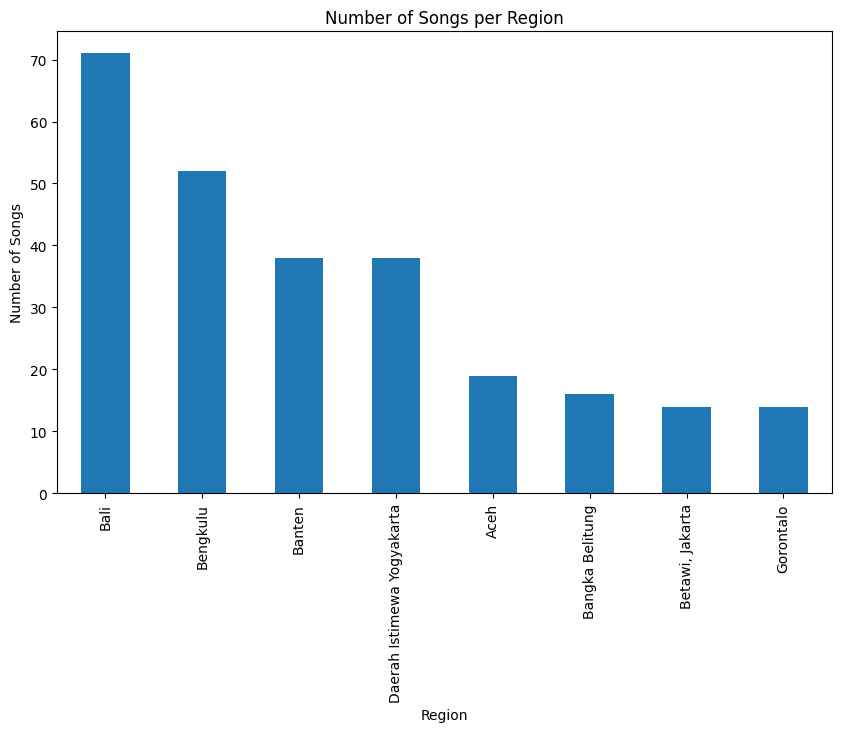

In [13]:
import matplotlib.pyplot as plt

# Count the number of songs per region
region_counts = df['region'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
region_counts.plot(kind='bar')
plt.title('Number of Songs per Region')
plt.xlabel('Region')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.show()